In [1]:
# ipython settings
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import mean_squared_error # we are going to assess the quality of the model based on the generalization MSE
from sklearn.metrics import accuracy_score
from sympy import init_printing # We use sympy to display mathematical expresssions 
import numpy as np # we use numpy to deal with arrays
import lime 
import lime.lime_tabular
init_printing()

In [3]:
def f(X):
    X = np.array(X)
    Y = np.zeros((X.shape[0], 2))
    radius = 0.4**2
    margin = 0.01
    center = (0.5, 0.5)
        
    Y[(X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2 <= radius - margin, 0] = 1.
    Y[(X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2 <= radius - margin, 1] = 0.
    
    Y[(radius - margin < (X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2) *\
          ((X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2 <= radius), 0] = .75
    Y[(radius - margin < (X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2) *\
          ((X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2 <= radius), 1] = .25
    

    Y[(radius < (X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2) *\
          ((X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2 <= radius + margin), 0] = .25
    Y[(radius < (X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2) *\
          ((X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2 <= radius + margin), 1] = .75
    
    Y[(X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2 > (radius + margin), 0] = 0.
    Y[(X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2 > (radius + margin), 1] = 1.
    
    return Y

dim_X = 2

In [4]:
n_pts = 100
X = np.random.uniform(0, 1, (n_pts, dim_X))

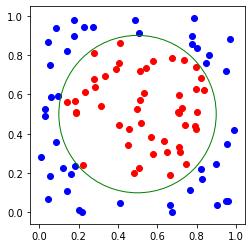

In [5]:
import matplotlib.pyplot as plt
y = f(X)
figure, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0.5, 0.5), 0.4, color='g', fill=False)
ax.add_artist(circle)
ax.scatter(X[:, 0][y[:, 0] > 0.75], X[:, 1][y[:, 0] > 0.75], c='r')
ax.scatter(X[:, 0][y[:, 1] > 0.75], X[:, 1][y[:, 1] > 0.75], c='b')

plt.savefig("syndata.png")
plt.show()


In [53]:
n_test = 10
X_test = np.random.uniform(0, 1, (n_test, dim_X))

<Figure size 432x288 with 0 Axes>

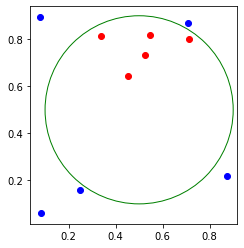

In [54]:
import matplotlib.pyplot as plt
y_ = f(X_test)
plt.clf()
figure, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0.5, 0.5), 0.4, color='g', fill=False)
ax.add_artist(circle)
ax.scatter(X_test[:, 0][y_[:, 0] > 0.75], X_test[:, 1][y_[:, 0] > 0.75], c='r')
ax.scatter(X_test[:, 0][y_[:, 1] > 0.75], X_test[:, 1][y_[:, 1] > 0.75], c='b')
plt.show()

In [34]:
from symbolic_pursuit.classification import SymbolicClassifier  # our symbolic model class

symbolic_model = SymbolicClassifier(verbosity=True,
                                    maxiter=20,
                                    nclasses=2,
                                   loss_tol = 0.1)
symbolic_model.fit(f, X, nmax=1)

Model created with the following hyperparameters :
 loss_tol=0.1 
 ratio_tol=0.9 
 maxiter=20 
 eps=0.001 
 random_seed=42
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Now working on term number  1 .
Now working on hyperparameter tree number  1 .
Optimization terminated successfully.
         Current function value: 0.680201
         Iterations: 0
         Function evaluations: 12
         Gradient evaluations: 1
Now working on hyperparameter tree number  2 .
Optimization terminated successfully.
         Current function value: 0.679978
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 1
Now working on hyperparameter tree number  3 .
         Current function value: 0.670023
         Iterations: 1
         Function evaluations: 1722
         Gradient evaluations: 95
The tree number  3  was selected as the best.
Backfitting complete.
The current model has the following expression:  [0.94868661

In [35]:
symbolic_weight_list = [] 
for k in range(n_test):
    symbolic_weight_list.append(symbolic_model.get_feature_importance(X_test[k]))

In [36]:
print (symbolic_weight_list)

[[-0.576554806164241, -0.576554806164241], [-0.633513679889680, -0.633513679889680], [-0.459108436125776, -0.459108436125777], [-0.360672646744055, -0.360672646744055], [-0.365247774421318, 0.367247774421318], [-0.522421332745562, -0.522421332745562], [-0.299486283005401, -0.299486283005401], [-0.314684796800806, -0.314684796800806], [-0.517283066705361, -0.517283066705361], [-0.333850611906933, 0.335850611906933]]


In [37]:
relative_wts = np.array(symbolic_weight_list)[np.argmax(f(X_test), 1) == 0]
relative_wts /= relative_wts[:, 0][..., None]
print (np.mean(relative_wts[:, 1]), np.var(relative_wts[:, 1]))

1.00000000000000 9.86076131526265e-33


In [38]:
poly1 = symbolic_model.get_taylor(X_test[0], approx_order=2)
poly2 = symbolic_model.get_taylor(X_test[3], approx_order=2)

print(poly1)
print(poly2)

-0.226189134146166*X0 - 0.531420765229984*X1 + 0.273326146443558*(0.425630966919929*X0 + X1 - 0.588740172455506)**2 + 0.640502858076188
-0.141642701157138*X0 - 0.33278288509441*X1 + 0.1899755938056*(0.40860255436501*X0 + 0.959992543122168*X1 - 1)**2 + 0.481888761468432


In [39]:
symbolic_model.terms_list[-1]

[[<pysymbolic.models.special_functions.MeijerG at 0x7fcb97827f10>,
 array([ 0.49812508, -0.13470852,  0.6482225 ,  1.52296838]),
 array([0.94868662, 0.9869837 ])]

In [55]:
accuracy_score(np.argmax(symbolic_model.predict(X_test), 1), np.argmax(f(X_test), 1))

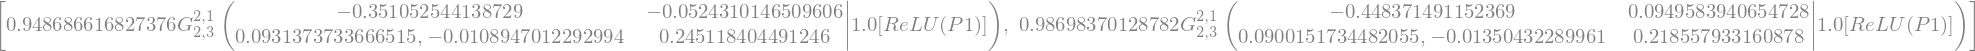

In [41]:
symbolic_model.get_expression()

In [ ]:
def order_weights(exp_list):
    ordered_weights = [0 for _ in range(dim_X)]
    for tup in exp_list:
        feature_id = int(tup[0].split('x_')[1][0])
        ordered_weights[feature_id-1] = tup[1]    
    return ordered_weights   

In [ ]:
lime_weight_list = []
explainer = lime.lime_tabular.LimeTabularExplainer(X, 
                                                   feature_names=["x_"+str(k) for k in range(1,dim_X+1)], 
                                                   class_names=['f'], 
                                                   verbose=False,
                                                   mode='classification')

for i in range(n_test):
    exp = explainer.explain_instance(X_test[i], f, num_features=dim_X)
    lime_weight_list.append(order_weights(exp.as_list()))  
                            
print(lime_weight_list) 

In [ ]:
relative_wts = np.array(lime_weight_list)
relative_wts /= relative_wts[:, 0][..., None]
print (np.mean(relative_wts[:, 1]), np.var(relative_wts[:, 1]))

In [ ]:
-0.226189134146166*x - 0.531420765229984*y + 0.273326146443558*(0.425630966919929*x + y - 0.588740172455506)^2 + 0.640502858076188 = 0